In [31]:
import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np 
import statsmodels.api as sm
import networkx as nx
import seaborn as sns

from spikeometric.models import BernoulliGLM
from spikeometric.datasets import NormalGenerator, ConnectivityDataset
from spikeometric.stimulus import RegularStimulus

from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj, to_networkx, from_networkx
from CD_methods import SCM_learner, observational_learner, interventional_learner
from functions import *

from tqdm import tqdm

In [32]:
network_data = torch.load('data/c_elegans_data.pt')

with open('data/c_elegans_spike_data_single_node_stimuli.pickle', 'rb') as f:
    spike_data = pickle.load(f)

In [51]:
n_neurons = network_data.num_nodes
G = to_networkx(network_data, node_attrs = ['position'])
position_dict = nx.get_node_attributes(G, 'position')

# sample neurons
n_obs = 20
#index_obs = np.sort(np.random.choice(n_neurons, size = n_obs, replace = False))

xy_position_dict = dict()
for node in position_dict:
    y = np.random.random()
    x = position_dict[node]
    xy_position_dict[node] = np.array([x, y])

sample_space = []
upper = 0.25
lower = 0.
for neuron in position_dict:
    if position_dict[neuron] > lower and position_dict[neuron] < upper:
        sample_space.append(neuron)
print('size of sample space =',len(sample_space))
index_obs = np.sort(np.random.choice(sample_space, size = n_obs, replace = False))
#print('observed nodes: ',index_obs)
G_true = nx.subgraph(G, index_obs)

size of sample space = 165


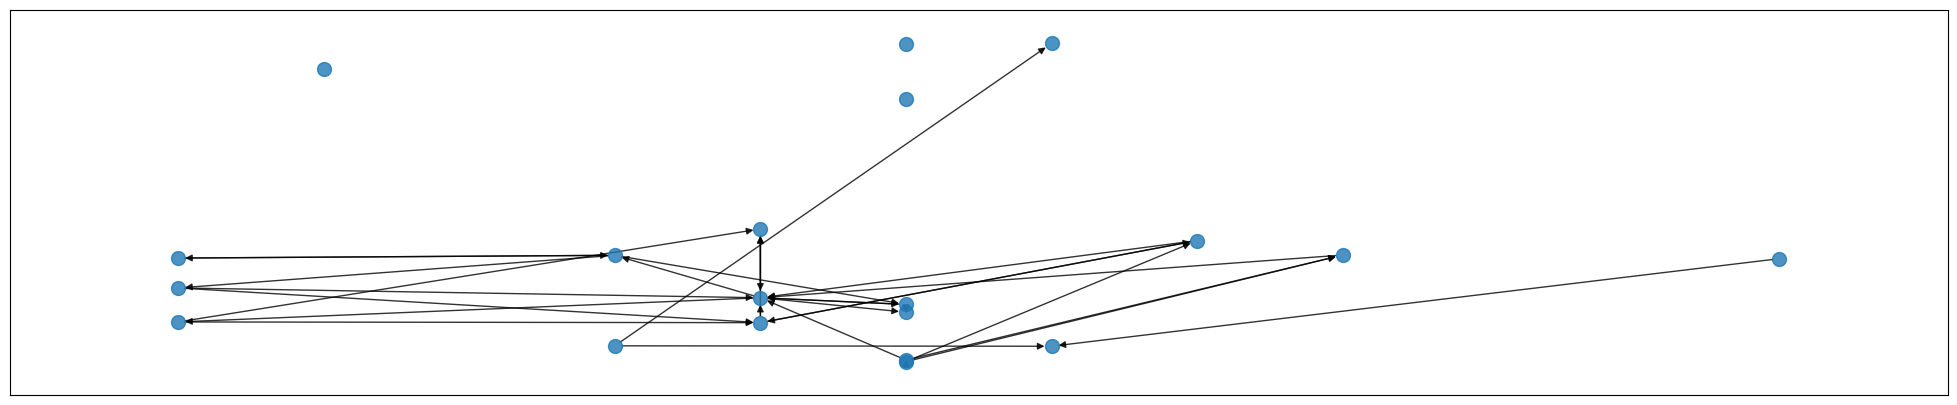

In [52]:
plt.figure(figsize=(25,5))
nx.draw_networkx(G_true, 
                 pos=xy_position_dict, 
                 arrows=True, 
                 with_labels=False, 
                 arrowsize=10, 
                 node_size=100, 
                 alpha=0.8)
plt.show()

In [53]:
G_observational = observational_learner(
    spike_data['null'][index_obs], 
    node_list=index_obs, 
    alpha = 0.01)

In [54]:
SHD_null = compute_SHD(G_true=G_true, G_learned=G_observational)
print(SHD_null)

5


In [55]:
degree_sequence = sorted((d for n, d in G_observational.degree()), reverse=True)
in_degree_sequence = sorted((d for n, d in G_observational.in_degree()), reverse=True)
out_degree_sequence = sorted((d for n, d in G_observational.out_degree()), reverse=True)

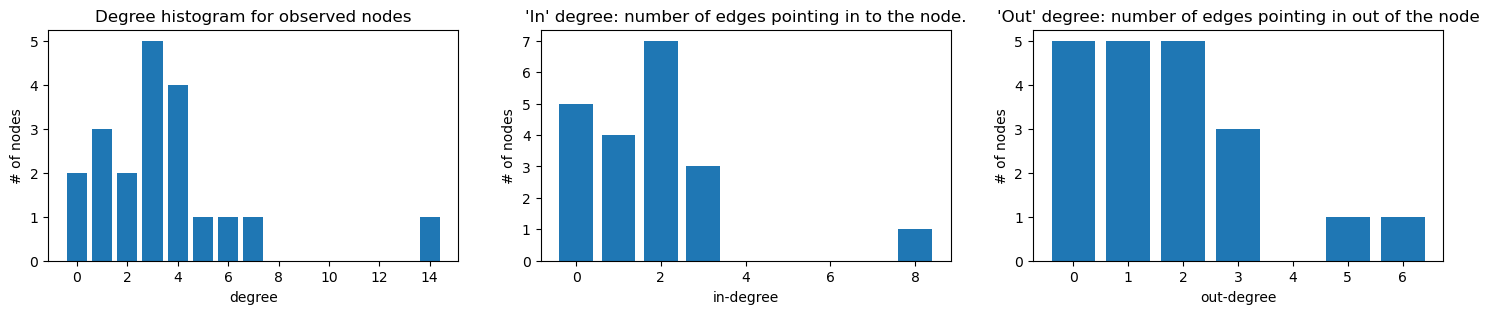

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(18, 3))

ax[0].bar(*np.unique(degree_sequence, return_counts=True))
ax[0].set_title("Degree histogram for observed nodes")
ax[0].set_xlabel("degree")
ax[0].set_ylabel("# of nodes")

ax[1].bar(*np.unique(in_degree_sequence, return_counts=True))
ax[1].set_title("'In' degree: number of edges pointing in to the node.")
ax[1].set_xlabel("in-degree")
ax[1].set_ylabel("# of nodes")

ax[2].bar(*np.unique(out_degree_sequence, return_counts=True))
ax[2].set_title("'Out' degree: number of edges pointing in out of the node")
ax[2].set_xlabel("out-degree")
ax[2].set_ylabel("# of nodes")
plt.show()

In [57]:
high_degree_node, _ = sorted(G_observational.out_degree, key=lambda x: x[1], reverse=True)[0]
nodes_by_out_degree = [node for node, _ in sorted(G_observational.out_degree, key=lambda x: x[1], reverse=True)]
nodes_by_degree = [node for node, _ in sorted(G_observational.degree, key=lambda x: x[1], reverse=True)]

In [58]:
intervention_sets = []
intervened_nodes_list = []

for node in nodes_by_out_degree:
    
    if node not in intervened_nodes_list:
        intervention_set = [node]
        intervened_nodes_list.append(node)
        
        target_nodes = [v for _, v in G_observational.out_edges(node)]
        nodes_not_target = [x for x in nodes_by_out_degree if x not in target_nodes and x!=node]

        for new_node in nodes_not_target:

            if new_node in intervened_nodes_list:
                continue
            
            new_node_targets = [v for _, v in G_observational.out_edges(new_node)]
            new_node_sources = [u for u, _ in G_observational.in_edges(new_node)]
            
            if not new_node_targets: # if node has no targets
                intervened_nodes_list.append(new_node)
                continue
            
            targets_no_overlap = len(set(target_nodes + new_node_targets)) == len(new_node_targets + target_nodes)
            new_node_targets_not_in_invervention_set = len(set(new_node_targets + intervention_set)) == len(new_node_targets + intervention_set)
            new_node_sources_not_in_invervention_set = len(set(new_node_sources + intervention_set)) == len(new_node_sources + intervention_set)
            
            if targets_no_overlap and new_node_targets_not_in_invervention_set and new_node_sources_not_in_invervention_set:
                target_nodes.extend(new_node_targets)
                intervention_set.append(new_node)
                intervened_nodes_list.append(new_node)
                
        intervention_sets.append(intervention_set)

In [59]:
num_out_edges = []
for intervention_set in intervention_sets:
    N = 0
    for node in intervention_set:
        N += len(G_observational.out_edges(node))
    num_out_edges.append(N)

In [60]:
intervention_sets
total_interventions = 0
for x in intervention_sets:
    total_interventions += len(x)  
print(total_interventions)

15


In [61]:
#print(intervention_sets)
zip(intervention_sets,num_out_edges)
sorted_intervention_sets = [x for y, x in sorted(zip(num_out_edges, intervention_sets), reverse=True)]
sorted_intervention_sets

[[255, 149, 42],
 [99, 276],
 [213, 18],
 [188, 27, 165],
 [208],
 [72],
 [33],
 [250],
 [47]]

## Do interventions

In [62]:
# set up the neuron model
neuron_model = BernoulliGLM(
    theta=3.,
    dt=1.,
    coupling_window=1,
    abs_ref_scale=3,
    abs_ref_strength=-100,
    rel_ref_scale=0,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0.2,
    r = 1
)

In [63]:
SHD_out_degree_multiple_protocol = [SHD_null]
G_learned = G_observational.copy()
for intervention in intervention_sets:    
    spike_data_obs = dict()
    
    # do stimulation
    stimulus_mask = torch.zeros(n_neurons, dtype=torch.bool)
    stimulus_mask[intervention] = True
    intervention_str = '_'.join(str(x) for x in intervention) 
    
    neuron_model.add_stimulus(lambda t: 2*stimulus_mask)
    spikes = neuron_model.simulate(network_data, n_steps=10**4, verbose=False)    
    spike_data_obs[intervention_str] = spikes[index_obs]    
    
    G_learned = interventional_learner(
        spike_data_obs,
        node_list=index_obs, 
        stimulation_protocol=[intervention],
        SCM_learned=G_learned,
        alpha = 1e-5,
        verbose=True)
    
    SHD_out_degree_multiple_protocol.append(compute_SHD(G_true=G_true, G_learned=G_learned))

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 54.32it/s]


In [64]:
print('SHD =',compute_SHD(G_learned=G_learned, G_true=G_true))
print('sensitivity =',compute_sensitivity(G_learned=G_learned, G_true=G_true, nodelist=index_obs))
print('specificity =', compute_specificity(G_learned=G_learned, G_true=G_true, nodelist=index_obs))

SHD = 0
sensitivity = 1.0
specificity = 1.0


In [65]:
SHD_out_degree_multiple_sorted_protocol = [SHD_null]
G_learned = G_observational.copy()

for intervention in sorted_intervention_sets:    
    spike_data_obs = dict()
    
    # do stimulation
    stimulus_mask = torch.zeros(n_neurons, dtype=torch.bool)
    stimulus_mask[intervention] = True
    intervention_str = '_'.join(str(x) for x in intervention) 
    
    neuron_model.add_stimulus(lambda t: 2*stimulus_mask)
    spikes = neuron_model.simulate(network_data, n_steps=10**4, verbose=False)    
    spike_data_obs[intervention_str] = spikes[index_obs]    
    
    G_learned = interventional_learner(
        spike_data_obs,
        node_list=index_obs, 
        stimulation_protocol=[intervention],
        SCM_learned=G_learned,
        alpha = 1e-5,
        verbose=True)
    
    SHD_out_degree_multiple_sorted_protocol.append(compute_SHD(G_true=G_true, G_learned=G_learned))

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 184.32it/s]


In [66]:
print('SHD =',compute_SHD(G_learned=G_learned, G_true=G_true))
print('sensitivity =',compute_sensitivity(G_learned=G_learned, G_true=G_true, nodelist=index_obs))
print('specificity =', compute_specificity(G_learned=G_learned, G_true=G_true, nodelist=index_obs))

SHD = 0
sensitivity = 1.0
specificity = 1.0


In [67]:
SHD_out_degree_protocol = [SHD_null]
G_learned = G_observational.copy()
for stim_node in nodes_by_out_degree:
    
    stimulate_nodes = [stim_node]
    stimulation_protocol = [[i] for i in stimulate_nodes]
    spike_data_obs = dict()
    
    for intervention in stimulate_nodes:
        spike_data_obs[str(intervention)] = spike_data[str(intervention)][index_obs]
    
    G_learned = interventional_learner(
        spike_data_obs,
        node_list=index_obs, 
        stimulation_protocol=stimulation_protocol,
        SCM_learned=G_learned,
        alpha = 1e-5,
        verbose=False)
    
    SHD_out_degree_protocol.append(compute_SHD(G_true=G_true, G_learned=G_learned))

In [68]:
total_interventions = SHD_out_degree_protocol.index(0) + 1
print(total_interventions)

15


In [69]:
print('SHD =',compute_SHD(G_learned=G_learned, G_true=G_true))
print('sensitivity =',compute_sensitivity(G_learned=G_learned, G_true=G_true, nodelist=index_obs))
print('specificity =', compute_specificity(G_learned=G_learned, G_true=G_true, nodelist=index_obs))

SHD = 0
sensitivity = 1.0
specificity = 1.0


In [70]:
SHD_degree_protocol = [SHD_null]
G_learned = G_observational.copy()
for stim_node in nodes_by_degree:
    
    stimulate_nodes = [stim_node]
    stimulation_protocol = [[i] for i in stimulate_nodes]
    spike_data_obs = dict()

    for intervention in stimulate_nodes:
        spike_data_obs[str(intervention)] = spike_data[str(intervention)][index_obs]
    
    G_learned = interventional_learner(
        spike_data_obs,
        node_list=index_obs, 
        stimulation_protocol=stimulation_protocol,
        SCM_learned=G_learned,
        alpha = 1e-5,
        verbose=False)
    
    SHD_degree_protocol.append(compute_SHD(G_true=G_true, G_learned=G_learned))

In [71]:
print('SHD =',compute_SHD(G_learned=G_learned, G_true=G_true))
print('sensitivity =',compute_sensitivity(G_learned=G_learned, G_true=G_true, nodelist=index_obs))
print('specificity =', compute_specificity(G_learned=G_learned, G_true=G_true, nodelist=index_obs))

SHD = 0
sensitivity = 1.0
specificity = 1.0


In [72]:
nodes_random_selection = np.random.choice(index_obs, size = len(index_obs), replace = False)
#print(nodes_random_selection)

In [73]:
SHD_random_protocol = [SHD_null]
G_learned = G_observational.copy()

for stim_node in nodes_random_selection:
    
    stimulate_nodes = [stim_node]
    stimulation_protocol = [[i] for i in stimulate_nodes]
    spike_data_obs = dict()
    spike_data_obs['null'] = spike_data['null'][index_obs]
    for intervention in stimulate_nodes:
        spike_data_obs[str(intervention)] = spike_data[str(intervention)][index_obs]
    
    G_learned = interventional_learner(
        spike_data_obs,
        node_list=index_obs, 
        stimulation_protocol=stimulation_protocol,
        SCM_learned=G_learned,
        alpha = 1e-5,
        verbose=False)
    
    SHD_random_protocol.append(compute_SHD(G_true=G_true, G_learned=G_learned))

In [74]:
total_interventions = SHD_random_protocol.index(0) + 1
print(total_interventions)

18


In [75]:
print('SHD =',compute_SHD(G_learned=G_learned, G_true=G_true))
print('sensitivity =',compute_sensitivity(G_learned=G_learned, G_true=G_true, nodelist=index_obs))
print('specificity =', compute_specificity(G_learned=G_learned, G_true=G_true, nodelist=index_obs))

SHD = 0
sensitivity = 1.0
specificity = 1.0


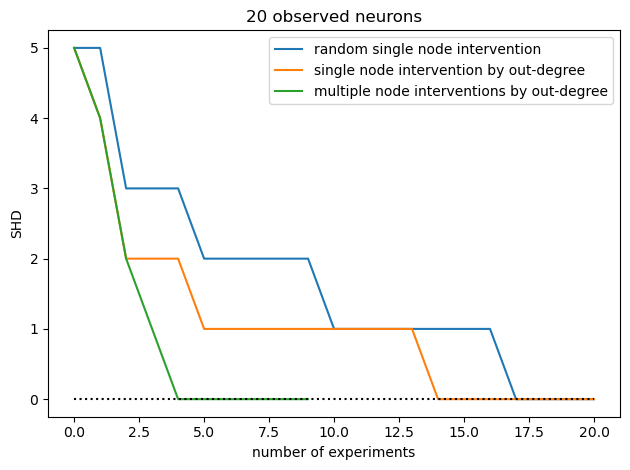

In [76]:
plt.plot(SHD_random_protocol, label='random single node intervention')
#plt.plot(SHD_degree_protocol, label='intervention by degree')
plt.plot(SHD_out_degree_protocol, label='single node intervention by out-degree')
plt.plot(SHD_out_degree_multiple_protocol, label='multiple node interventions by out-degree')
#plt.plot(SHD_out_degree_multiple_sorted_protocol, label='sorted multiple intervention by out-degree')
#plt.plot(SHD_out_active_degree_multiple_protocol, label='active multiple intervention by out-degree')
plt.title(f'{n_obs} observed neurons')
plt.hlines(y=0, xmin=0, xmax=len(index_obs), linestyles='dotted', color='black')
plt.legend()
plt.xlabel('number of experiments')
plt.ylabel('SHD')
plt.tight_layout()
plt.show()

## Notes
- Doing high degree out node experiments first improved convergence
- By doing multiple stimulation of nodes that have high degree and no overlapping nodes (they do not interact with each other and they do not have any mutual targets) we reduce the number of total experiments
- Sorting intervention sets by what sets have the largest total number of out degrees improves convergence slightly
- There seems to be some confounding or other interference to the learning algorithm with multiple interventions
    - Should I use weaker stimulation?
    - Change the sig. level?
    - is there a graphical criterion I'm missing?
- May look at active learning, where every learning step can inform intervention set.
    - Meaning, after an intervention set has updated the learned graph, I will intervene on the nodes that have highest out degree in the learned graph AND that have not yet been intervened on. I think (?) this should make the graph identifiable.
    
- Mer optogenetisk realistiske settinger
- Se på hvordan fordeling av gener, lysintensitet påvirker confounding
- Korte eller lange impulser, antall tilfeldig valgte nevroner
- Tofoton gir mer kontroll, se på hva som skjer hvis det er litt støy, sammenlign med puls og konstant stim
- Sammenligne single foton og tofoton
- Flere lyskilder, pulse dem i et mønster som gir bedre resultater


In [27]:
intervention_sets = []
intervened_nodes_list = []

for node in nodes_by_out_degree:
    
    if node not in intervened_nodes_list:
        intervention_set = [node]
        intervened_nodes_list.append(node)
        
        target_nodes = [v for _, v in G_observational.out_edges(node)]
        nodes_not_target = [x for x in nodes_by_out_degree if x not in target_nodes and x!=node]

        for new_node in nodes_not_target:

            if new_node in intervened_nodes_list:
                continue
            
            new_node_targets = [v for _, v in G_observational.out_edges(new_node)]
            new_node_sources = [u for u, _ in G_observational.in_edges(new_node)]
            
            if not new_node_targets: # if node has no targets
                intervened_nodes_list.append(new_node)
                continue
            
            targets_no_overlap = len(set(target_nodes + new_node_targets)) == len(new_node_targets + target_nodes)
            new_node_targets_not_in_invervention_set = len(set(new_node_targets + intervention_set)) == len(new_node_targets + intervention_set)
            new_node_sources_not_in_invervention_set = len(set(new_node_sources + intervention_set)) == len(new_node_sources + intervention_set)
            
            if targets_no_overlap and new_node_targets_not_in_invervention_set and new_node_sources_not_in_invervention_set:
                target_nodes.extend(new_node_targets)
                intervention_set.append(new_node)
                intervened_nodes_list.append(new_node)
                
        intervention_sets.append(intervention_set)

In [28]:
intervened_nodes_list = []
node = nodes_by_out_degree[0]
intervention_set = [node]
intervened_nodes_list.append(node)
nodes_remaining = nodes_by_out_degree.copy()
nodes_remaining.remove(node)

target_nodes = [v for _, v in G_observational.out_edges(node)]
nodes_not_target = [x for x in nodes_by_out_degree if x not in target_nodes and x!=node]

for new_node in nodes_not_target:

    if new_node in intervened_nodes_list:
        continue

    new_node_targets = [v for _, v in G_observational.out_edges(new_node)]
    new_node_sources = [u for u, _ in G_observational.in_edges(new_node)]

    if not new_node_targets: # if node has no targets
        intervened_nodes_list.append(new_node)
        continue

    targets_no_overlap = len(set(target_nodes + new_node_targets)) == len(new_node_targets + target_nodes)
    new_node_targets_not_in_invervention_set = len(set(new_node_targets + intervention_set)) == len(new_node_targets + intervention_set)
    new_node_sources_not_in_invervention_set = len(set(new_node_sources + intervention_set)) == len(new_node_sources + intervention_set)

    if targets_no_overlap and new_node_targets_not_in_invervention_set and new_node_sources_not_in_invervention_set:
        target_nodes.extend(new_node_targets)
        intervention_set.append(new_node)
        intervened_nodes_list.append(new_node)
        nodes_remaining.remove(new_node)


In [29]:
intervention_set

[94, 195, 31, 204, 205, 24, 182]

In [30]:
SHD_out_active_degree_multiple_protocol = []
G_learned = G_observational.copy()
while nodes_remaining:
    print(intervention_set)

    spike_data_obs = dict()
    
    # do stimulation
    stimulus_mask = torch.zeros(n_neurons, dtype=torch.bool)
    stimulus_mask[intervention_set] = True
    intervention_str = '_'.join(str(x) for x in intervention_set) 
    
    neuron_model.add_stimulus(lambda t: 2*stimulus_mask)
    spikes = neuron_model.simulate(network_data, n_steps=10**4, verbose=False)    
    spike_data_obs[intervention_str] = spikes[index_obs]    
    
    G_learned = interventional_learner(
        spike_data_obs,
        node_list=index_obs, 
        stimulation_protocol=[intervention_set],
        SCM_learned=G_learned,
        alpha = 1e-4,
        verbose=True)
    
    node = nodes_remaining[0]
    intervention_set = [node]
    intervened_nodes_list.append(node)
    nodes_remaining.remove(node)

    target_nodes = [v for _, v in G_observational.out_edges(node)]
    nodes_not_target = [x for x in nodes_by_out_degree if x not in target_nodes and x!=node]

    for new_node in nodes_not_target:

        if new_node in intervened_nodes_list:
            continue

        new_node_targets = [v for _, v in G_observational.out_edges(new_node)]
        new_node_sources = [u for u, _ in G_observational.in_edges(new_node)]

        if not new_node_targets: # if node has no targets
            intervened_nodes_list.append(new_node)
            continue

        targets_no_overlap = len(set(target_nodes + new_node_targets)) == len(new_node_targets + target_nodes)
        new_node_targets_not_in_invervention_set = len(set(new_node_targets + intervention_set)) == len(new_node_targets + intervention_set)
        new_node_sources_not_in_invervention_set = len(set(new_node_sources + intervention_set)) == len(new_node_sources + intervention_set)

        if targets_no_overlap and new_node_targets_not_in_invervention_set and new_node_sources_not_in_invervention_set:
            target_nodes.extend(new_node_targets)
            intervention_set.append(new_node)
            intervened_nodes_list.append(new_node)
            nodes_remaining.remove(new_node)
    
    SHD_out_active_degree_multiple_protocol.append(compute_SHD(G_true=G_true, G_learned=G_learned))

[94, 195, 31, 204, 205, 24, 182]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.94it/s]


[265, 112, 216, 249, 25, 137, 114, 183, 206, 236]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.69it/s]


[55, 42, 223, 178, 201, 228, 67]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 19.66it/s]


[176, 139, 141, 146, 3, 116]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.88it/s]


[105, 40, 226, 23, 237]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 36.12it/s]


[260, 221, 224]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 45.96it/s]


[83, 189]


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 76.42it/s]


[7]


100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]


[16]


100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


[84]


100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


[106]


100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


[119]


KeyboardInterrupt: 